In [37]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()

  Activating environment at `~/SSD/Code/Julia/tinympc-julia/safety_filter/Project.toml`


In [38]:
using LinearAlgebra
using PyPlot
using Printf
using Random

In [39]:
include("../LibTinyMPC_clean.jl")

export_mat_to_c (generic function with 1 method)

In [118]:
#Rocket landing
NSTATES = 6
NINPUTS = 3
NHORIZON = 35
NTOTAL = 101

# Initialize cache, settings, bounds, socs, workspace, solver

###### Cache
rho = 1e0
Kinf = zeros(NINPUTS,NSTATES)
Pinf = zeros(NSTATES,NSTATES)
Quu_inv = zeros(NINPUTS,NINPUTS)
AmBKt = zeros(NSTATES,NSTATES)
APf = zeros(NSTATES)
BPf = zeros(NINPUTS)
my_cache = TinyCache(rho, Kinf, Pinf, Quu_inv, AmBKt, APf, BPf)
#####

##### Settings
abs_pri_tol = 1e-2
abs_dua_tol = 1e-2
max_iter = 100
check_termination = 1
en_state_bound = 0 # ENABLE CONSTRAINTS OR NOT
en_input_bound = 1
en_state_soc = 0
en_input_soc = 0
my_stgs = TinySettings(abs_pri_tol, abs_dua_tol, max_iter, check_termination, en_state_bound, en_input_bound, en_state_soc, en_input_soc)
#####

###### Bounds
umin = -3*ones(NINPUTS, NHORIZON-1)
umax = 3*ones(NINPUTS, NHORIZON-1)
xmin = repeat([-5; -5; -5; -5; -5; -5], 1, NHORIZON)
xmax = repeat([5; 5; 5.0; 5; 5; 5], 1, NHORIZON)
z = zeros(NINPUTS, NHORIZON-1)
znew = zeros(NINPUTS, NHORIZON-1)
v = zeros(NSTATES, NHORIZON)
vnew = zeros(NSTATES, NHORIZON)
y = zeros(NINPUTS, NHORIZON-1)
g = zeros(NSTATES, NHORIZON)
my_bounds = TinyBounds(umin, umax, xmin, xmax, z, znew, v, vnew, y, g)
#####

##### SOCS
ncu = 1
ncx = 1
cu = [0.4, 0]  # 0.3 is the thrust coefficient
cx = [0.6, 0]
qcu = [3, 0]  # 3 is the dimensions of 1st cone
qux = [3, 0]
Acu = [1, 0]
Acx = [1, 0]
zc = [zeros(NINPUTS, NHORIZON-1), zeros(NINPUTS, NHORIZON-1)]
vc = [zeros(NSTATES, NHORIZON), zeros(NSTATES, NHORIZON)]
zcnew = [zeros(NINPUTS, NHORIZON-1), zeros(NINPUTS, NHORIZON-1)]
vcnew = [zeros(NSTATES, NHORIZON), zeros(NSTATES, NHORIZON)]
yc = [zeros(NINPUTS, NHORIZON-1), zeros(NINPUTS, NHORIZON-1)]
gc = [zeros(NSTATES, NHORIZON), zeros(NSTATES, NHORIZON)]
my_socs = TinySocs(ncu, ncx, cu, cx, qcu, qux, Acu, Acx, zc, zcnew, vc, vcnew, yc, gc)
#####

##### Workspace
x = zeros(NSTATES, NHORIZON)
u = zeros(NINPUTS, NHORIZON-1)
q = zeros(NSTATES, NHORIZON)
r = zeros(NINPUTS, NHORIZON-1)
p = zeros(NSTATES, NHORIZON)
d = zeros(NINPUTS, NHORIZON-1)
pri_res_state = 1.0
pri_res_input = 1.0
dua_res_state = 1.0
dua_res_input = 1.0
status = 0
iter = 0
Q = 1e2*I(NSTATES) # dont need to penalize the state in safety fitler
R = 1e0*I(NINPUTS)
#2D Double-integrator dynamics
h = 0.1 #20 Hz
temp_n = Int(NSTATES/2)
Adyn = [I(temp_n) h*I(temp_n); zeros(temp_n,temp_n) I(temp_n)]
Bdyn = [0.5*h*h*I(temp_n); h*I(temp_n)];
fdyn = zeros(NSTATES)

t = h*(0:NTOTAL-1)
Xref = zeros(NSTATES, NTOTAL)
# x0 = [4, 2, 20, -2, 3, -5.0]  # INITIAL STATE
x0 = [4, 2, 3, 1, -2, 2.0]
x[:,1] = 1*x0
xg = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
for k = 1:NTOTAL
  # Xref[1:3,k] = (x0 + (xg - x0)*(k-1)/(NTOTAL-1))[1:3]
end
Uref = repeat([0; 0; 0.0], 1, NTOTAL-1) 
Xref_hrz = 1*Xref[:,1:NHORIZON]
Uref_hrz = 1*Uref[:,1:NHORIZON-1]
# Could provide a better reference from other solvers

Qu = zeros(NINPUTS, NINPUTS)
my_work = TinyWorkspace(x, u, q, r, p, d, pri_res_state, pri_res_input, dua_res_state, dua_res_input, status, iter, Q, R, Adyn, Bdyn, fdyn, Xref_hrz, Uref_hrz, Qu, my_bounds, my_socs)
#####

# Solver
solver = TinySolver(my_stgs, my_cache, my_work)

TinySolver(TinySettings(0.01, 0.01, 100, 1, 0, 1, 0, 0), TinyCache(1.0, [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0]), TinyWorkspace([4.0 0.0 … 0.0 0.0; 2.0 0.0 … 0.0 0.0; … ; -2.0 0.0 … 0.0 0.0; 2.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], 1.0, 1.0, 1.0, 1.0, 0, 0, [100.0 0.0 … 0.0 0.0; 0.0 100.0 … 0.0 0.0; … ; 0.0 0.0 … 100.0 0.0; 0.0 0.0 … 0.0 100.0], [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0], [1.0 0.0 … 0.0 0.0;

In [119]:
compute_cache!(solver)

6-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [120]:
Knom = [4.77182  0.0      0.0      5.68453  0.0      0.0;
        0.0      4.77182  0.0      0.0      5.68453  0.0;
        0.0      0.0      4.77182  0.0      0.0      5.68453]  # nominal gain
function rollout!(Upred, x, Xref_hrz)
    xn = x*1
    for k = 1:NHORIZON-1
        Upred[:,k] = -Knom*(xn - Xref_hrz[:,k]) 
        xn = Adyn*xn + Bdyn*Upred[:,k] + fdyn
    end
end

rollout! (generic function with 1 method)

In [121]:
# MPC loop
en_safety_filter = 1 # ENABLE SAFETY FILTER OR NOT
solver.settings.en_state_bound = 1
solver.settings.en_state_soc = 0
xmin = repeat([-5; -5; -5; -5; -5; -5], 1, NHORIZON)
xmax = repeat([5; 5; 4.0; 5; 5; 5], 1, NHORIZON)

Random.seed!(1234)
Xhist = zeros(NSTATES, NTOTAL)
Xhist[:,1] .= x0 * 1.1
Uhist = zeros(NINPUTS, NTOTAL-1)
Upred = zeros(NINPUTS, NHORIZON-1)
solver.workspace.Uref = Upred # reference control input is from nominal rollout

NRUNS = NTOTAL-NHORIZON-1  
for i = 1:NRUNS
    # i%10 == 0 && print("i = ", i, "\n")
    # Get measurements
    pos_norm = norm(Xhist[1:3, i], Inf) / 1e2 # 1% noise
    vel_norm = norm(Xhist[4:6, i], Inf) / 1e4 # 1ppm noise
    noise_pos = randn(3)
    noise_vel = randn(3)
    solver.workspace.x[:,1] = Xhist[:,i] + 0*[noise_pos * pos_norm; noise_vel * vel_norm]
    # print("x = ", solver.workspace.x[:,1], "\n")

    # Nominal control rollout
    rollout!(Upred, solver.workspace.x[:,1], Xref[:,i:i+NHORIZON-1])
    Uhist[:,i] .= Upred[:,1]
    
    # Solve safety filter
    if en_safety_filter  == 1
        solve_admm!(solver)
        Uhist[:,i] .= solver.workspace.u[:,1]
    end

    # Clamp control input
    Uhist[:,i] = max.(min.(Uhist[:,i], umax[:,1]), umin[:,1])

    # print(Upred, "\n")
    # print(solver.workspace.u, "\n")
    # print(solver.workspace.x, "\n")

    # Simulate
    Xhist[:,i+1] .= Adyn*Xhist[:,i] + Bdyn*Uhist[:,i] + fdyn
end

In [122]:
vio_count = 0
for idx in 1:NRUNS
    # (sqrt(Uhist[1,idx]^2 + Uhist[2,idx]^2) - cu[1]*Uhist[3,idx] >= 1e-2) && (vio_count += 1)  # test cone constraint
    # (sqrt(Xhist[1,idx]^2 + Xhist[2,idx]^2) - cx[1]*Xhist[3,idx] >= 1e-2) && (vio_count += 1)  # test cone constraint
end
print("vio_count = ", vio_count, "\n")
print("max control = ", maximum(Uhist[:, 1:NRUNS]), "\n")
print("min control = ", minimum(Uhist[:, 1:NRUNS]), "\n")
print("max state = ", maximum(Xhist[1,:]))

vio_count = 0
max control = 2.4639622141453814
min control = -3.0
max state = 4.602866765361953

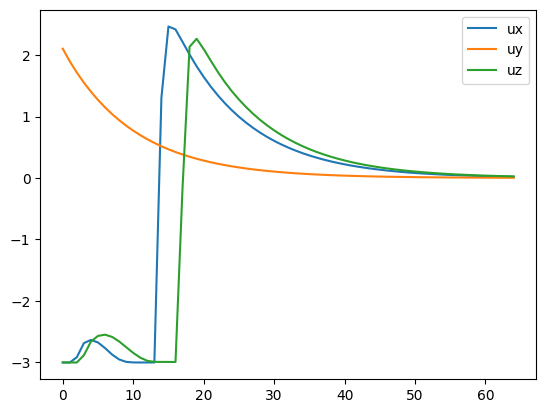

In [123]:
fig = plt.figure()
plot(Uhist[1, 1:NRUNS])
plot(Uhist[2, 1:NRUNS])
plot(Uhist[3, 1:NRUNS])
plt.legend(["ux", "uy", "uz"])
fig

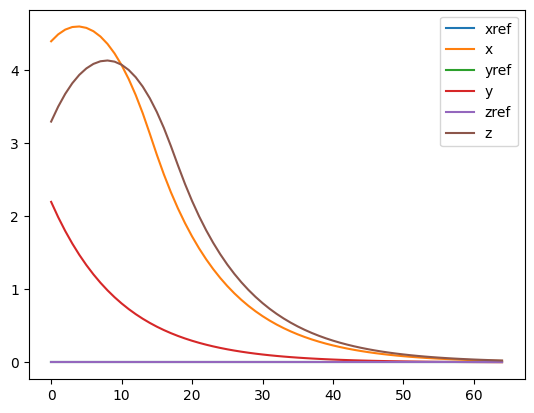

In [124]:
fig = plt.figure()
plot(Xref[1,1:NRUNS])
plot(Xhist[1,1:NRUNS])
plot(Xref[2,1:NRUNS]) 
plot(Xhist[2,1:NRUNS])
plot(Xref[3,1:NRUNS]) 
plot(Xhist[3,1:NRUNS])
plt.legend(["xref", "x", "yref", "y", "zref", "z"])
# put limit on axis
# plt.ylim(-5, 20)
# plt.xlim(0, 300)
fig